<a href="https://colab.research.google.com/github/TAlkam/Facial-Expression-Recognition/blob/main/Computer_Vision_Facial_Expression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>  <font style="color:rgb(100,109,254)">Facial Expression Recognition</font> </center>

In [1]:
# Import Required libraries
!pip install bleedfacedetector
import bleedfacedetector as fd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 11.3 MB/s eta 0:00:00


## <font style="color:rgb(134,19,348)"> Initialize the DNN module </font>
To use Models in ONNX format, you just have to use **`cv2.dnn.readNetFromONNX(model)`** and pass the model inside the function.

In [2]:
from google.colab import files

uploaded = files.upload()


Saving emotion-ferplus-8.onnx to emotion-ferplus-8.onnx


In [3]:
# Set model path
model = 'emotion-ferplus-8.onnx'
net = cv2.dnn.readNetFromONNX(model)

##  <font style="color:rgb(134,19,348)">Read Image</font>


In [4]:
from google.colab import files

uploaded = files.upload()


Saving bean_input.mp4 to bean_input.mp4
Saving bean_output.mp4 to bean_output.mp4
Saving emotion1.jpeg to emotion1.jpeg
Saving emotion2.jpg to emotion2.jpg
Saving emotion3.jpg to emotion3.jpg
Saving emotion4.jpg to emotion4.jpg
Saving emotion5.jpeg to emotion5.jpeg
Saving emotion6.jpg to emotion6.jpg


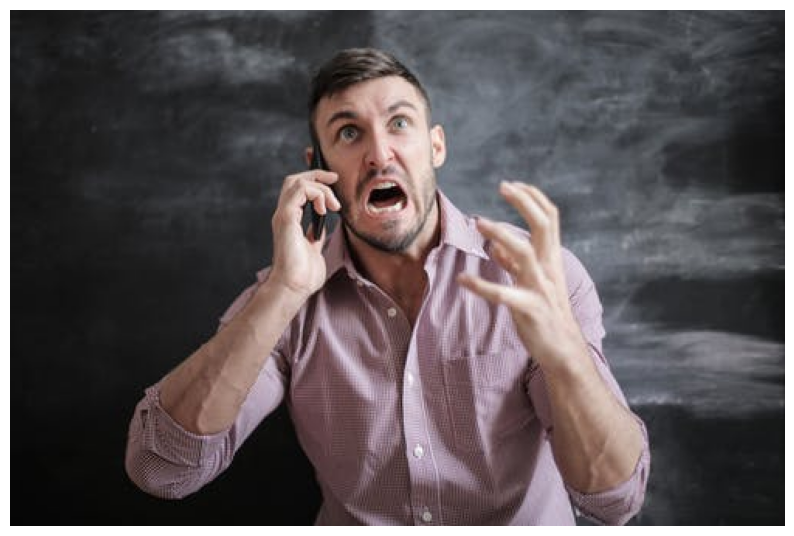

In [5]:
# Read image
image = cv2.imread("emotion1.jpeg")

# Display image
plt.figure(figsize=[10,10])
plt.imshow(image[:,:,::-1])
plt.axis('off');

**We'll be predicting among these Emotions.**

In [6]:
# Define the emotions
emotions = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Anger', 'Disgust', 'Fear', 'Contempt']

##  <font style="color:rgb(134,19,348)">Detect faces with bleedfacedetector</font>

In [7]:
img_copy = image.copy()

# Use SSD detector with 20% confidence threshold.
faces = fd.ssd_detect(img_copy, conf=0.2)

# Check the number detected faces in image
print("{} faces detected".format(len(faces)))

# Lets take coordinates of the first face in the image.
x,y,w,h = faces[0]

# Define padding for face roi
padding = 3

# extract the Face from image with padding.
padded_face = img_copy[y-padding:y+h+padding,x-padding:x+w+padding]

1 faces detected


##  <font style="color:rgb(134,19,348)">Padded vs Non Padded face  </font>

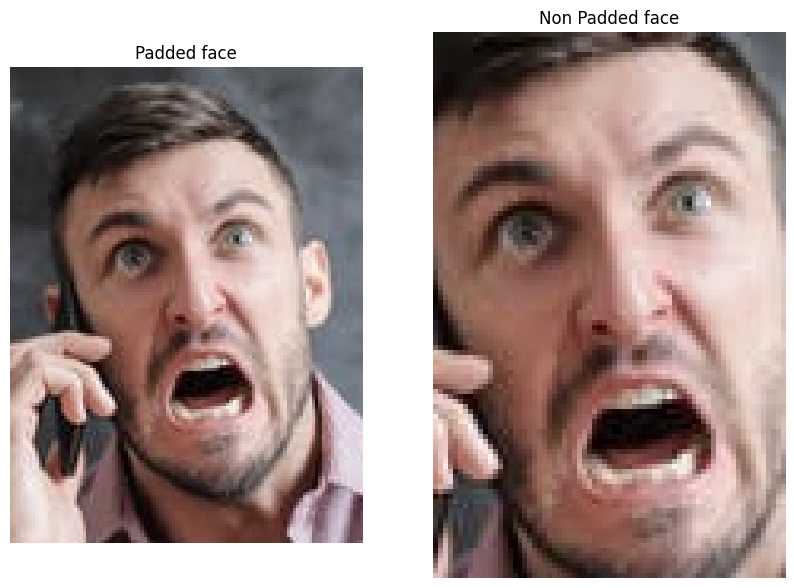

In [8]:
# Non Padded face
face = img_copy[y:y+h, x:x+w]

# Just increasing the padding for demo purpose
padding = 20

# Get the Padded face
padded_face_demo = img_copy[y-padding:y+h+padding,x-padding:x+w+padding]

plt.figure(figsize=[10, 10])
plt.subplot(121);plt.imshow(padded_face_demo[...,::-1]);plt.title("Padded face");plt.axis('off')
plt.subplot(122);plt.imshow(face[...,::-1]);plt.title("Non Padded face");plt.axis('off');

##  <font style="color:rgb(134,19,348)"> Pre-processing the image  </font>

In [9]:
gray = cv2.cvtColor(padded_face,cv2.COLOR_BGR2GRAY)
resized_face = cv2.resize(gray, (64, 64))
processed_face = resized_face.reshape(1,1,64,64)

## <font style="color:rgb(134,19,348)"> Input the Blob Image to the Network  </font>


In [10]:
net.setInput(processed_face)

##  <font style="color:rgb(134,19,348)">Forward Pass</font>


In [11]:
%%time
Output = net.forward()

CPU times: user 95.2 ms, sys: 6.91 ms, total: 102 ms
Wall time: 61.5 ms


In [12]:
# The output are the scores for each emotion class
print('Shape of Output: {} \n'.format(Output.shape))
print(Output)

Shape of Output: (1, 8) 

[[-0.8968601 -3.3136923  1.1349272 -1.3128643  3.5167465  0.9570387
   1.4894679 -1.251161 ]]


###  <font style="color:rgb(134,19,348)">Apply Softmax function to get Class Probabilities</font>
Now that we have scores for each class, we will convert these scores to probabilities between 0-1 by using a softmax function.

In [13]:
# Compute softmax values for each sets of scores
expanded = np.exp(Output - np.max(Output))
probablities =  expanded / expanded.sum()

# Get the final probablities
prob = np.squeeze(probablities)

print(prob)

[0.00909892 0.00081166 0.06940392 0.00600235 0.75126815 0.05809355
 0.09893707 0.00638438]


In [14]:
# Get the index of the max probability and that's your predicted emotion
predicted_emotion = emotions[prob.argmax()]

# Print the target Emotion
print('Predicted Emotion is :{}'.format(predicted_emotion ))

Predicted Emotion is :Anger


##  <font style="color:rgb(134,19,348)">Display Image</font>


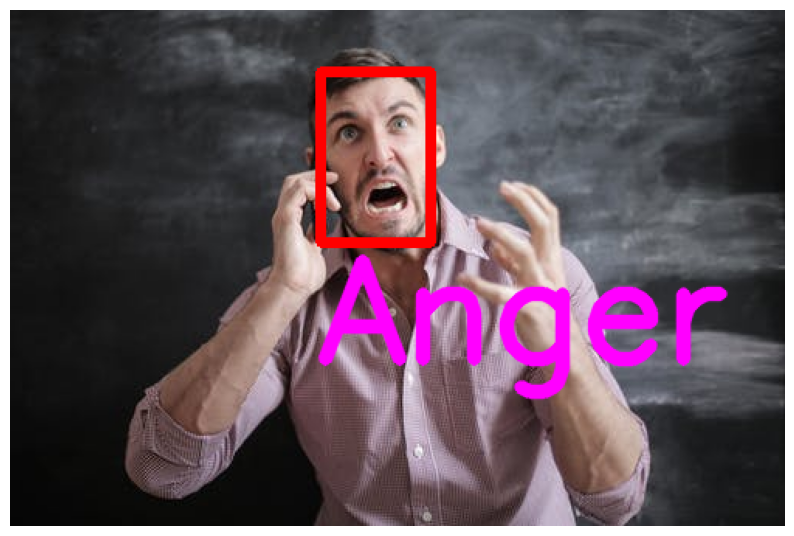

In [15]:
# Write predicted emotion on image
cv2.putText(img_copy,'{}'.format(predicted_emotion),(x,y+h+75), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,255), 7, cv2.LINE_AA)

# Draw rectangular box on detected face
cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,0,255),5)

# Display image
plt.figure(figsize=(10,10))
plt.imshow(img_copy[:,:,::-1]);plt.axis("off");

## <font style="color:rgb(134,19,348)"> Creating Functions </font>

## <font style="color:rgb(134,19,348)"> Initialization Function </font>
This method will be run once and it will initialize the network with the required files.

In [16]:
def init_emotion(model="emotion-ferplus-8.onnx"):

    # Set global variables
    global net,emotions

    # Define the emotions
    emotions = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Anger', 'Disgust', 'Fear', 'Contempt']

    # Initialize the DNN module
    net = cv2.dnn.readNetFromONNX(model)

## <font style="color:rgb(134,19,348)">  Main Method </font>

In [17]:
def emotion(image, returndata=False, confidence=0.3):

    # Make copy of  image
    img_copy = image.copy()

    # Detect face in image
    faces = fd.ssd_detect(img_copy,conf=confidence)

    # Define padding for face ROI
    padding = 3

    # Iterate process for all detected faces
    for x,y,w,h in faces:

        # Get the Face from image
        face = img_copy[y-padding:y+h+padding,x-padding:x+w+padding]

        # Convert the  detected face from BGR to Gray scale
        gray = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)

        # Resize the gray scale image into 64x64
        resized_face = cv2.resize(gray, (64, 64))

        # Reshape the final image in required format of model
        processed_face = resized_face.reshape(1,1,64,64)

        # Input the processed image
        net.setInput(processed_face)

        # Forwards pass
        Output = net.forward()

        #Compute softmax values for each sets of scores
        expanded = np.exp(Output - np.max(Output))
        probablities =  expanded / expanded.sum()

        # Get the final probablities
        prob = np.squeeze(probablities)

        # Get the predicted emotion
        predicted_emotion = emotions[prob.argmax()]

        # Write predicted emotion on image
        cv2.putText(img_copy,'{}'.format(predicted_emotion),(x,y+h+(1*20)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255),
                        2, cv2.LINE_AA)
        # Draw rectangular box on detected face
        cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,0,255),2)

    if  returndata:
        # Return the the final image if return data is is True
        return img_copy
    else:
        # Displpay the image
        plt.figure(figsize=(10,10))
        plt.imshow(img_copy[:,:,::-1]);plt.axis("off");

**Initialize the Emotion Recognizer**

In [18]:
!pip install onnxruntime
import onnxruntime as ort

ort_session = ort.InferenceSession("emotion-ferplus-8.onnx")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.6 MB/s eta 0:00:00


In [19]:
import onnxruntime as ort

def init_emotion(model_path):
    # Load the ONNX model with ONNX Runtime
    ort_session = ort.InferenceSession(model_path)



# Path to your ONNX model
model_path = 'emotion-ferplus-8.onnx'  # Make sure this is the correct path

# Initialize the emotion detection
init_emotion(model_path)


**Calling Emotion Recognizer with default arguments.**

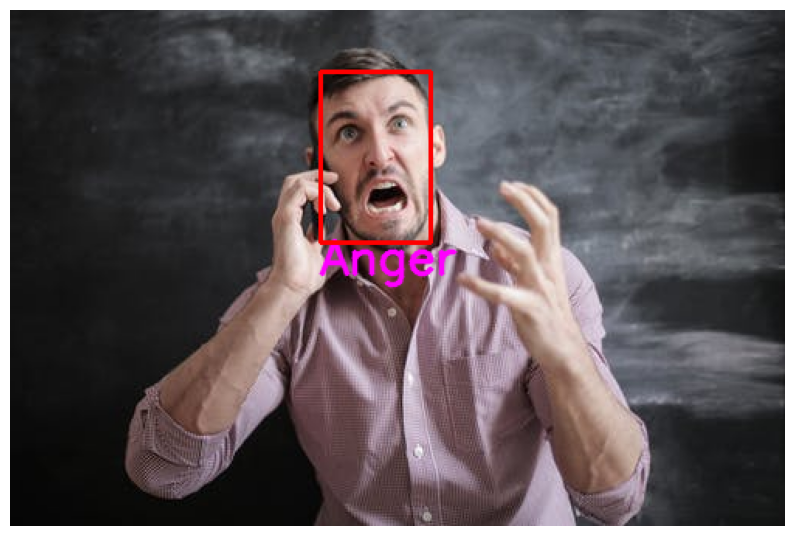

In [20]:
image = cv2.imread("emotion1.jpeg")
emotion(image)

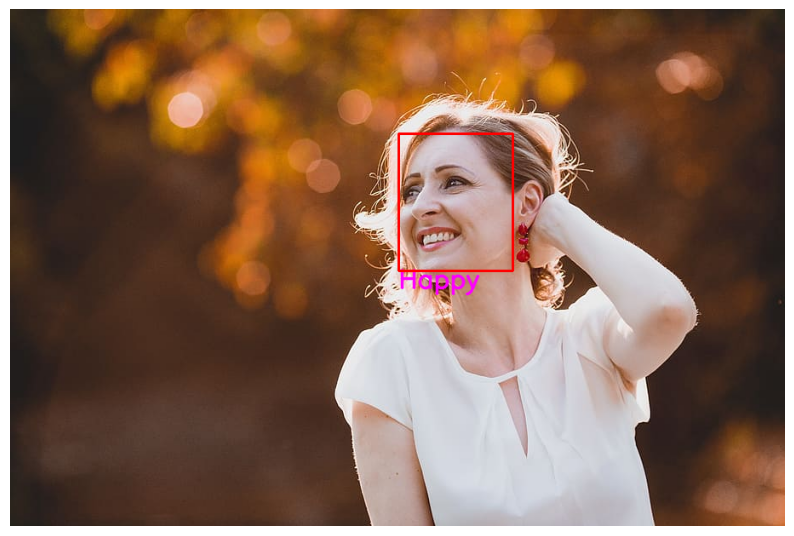

In [21]:
image = cv2.imread("emotion2.jpg")
emotion(image)

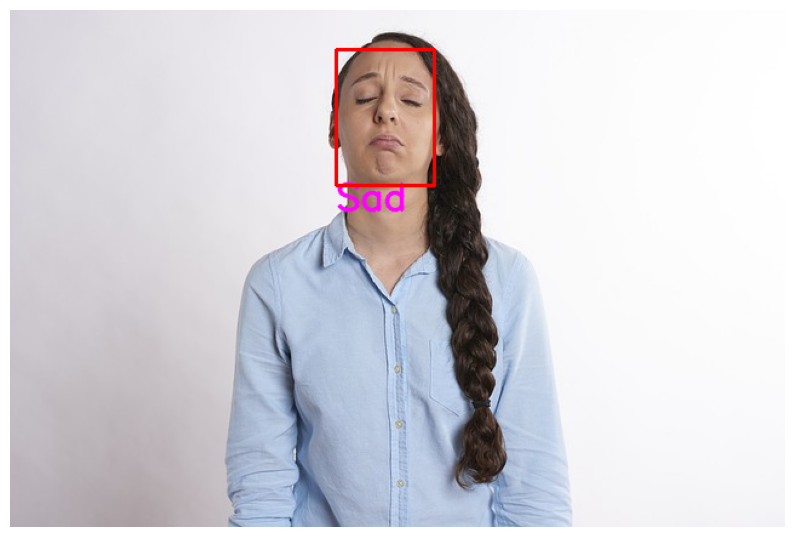

In [22]:
image = cv2.imread("emotion3.jpg")
emotion(image)

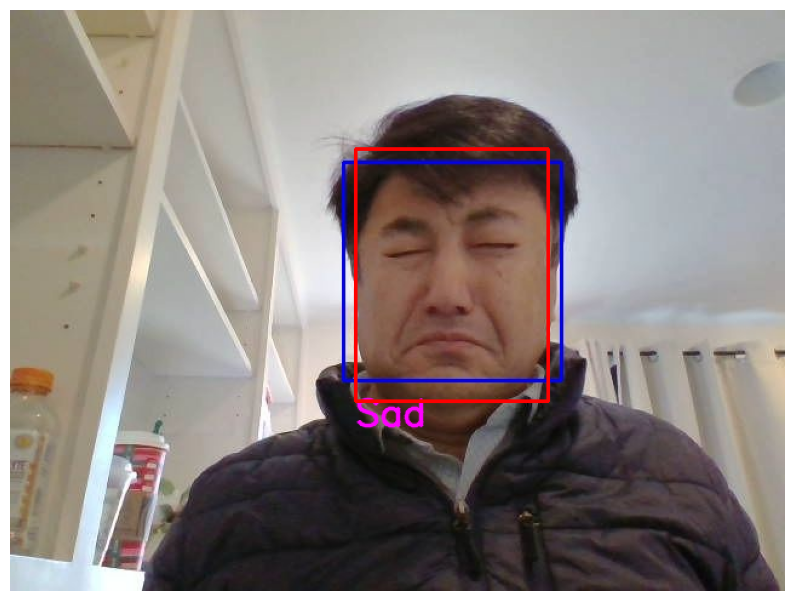

In [64]:
image = cv2.imread("webcamphoto.jpg")
emotion(image)

## <font style="color:rgb(134,19,348)"> Real time Emotion Recognition</font>

In [25]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

## Helper Functions
Below are a few helper function to make converting between different image data types and formats.

In [26]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model.

In [27]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Webcam Images
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [28]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to webcamphoto.jpg


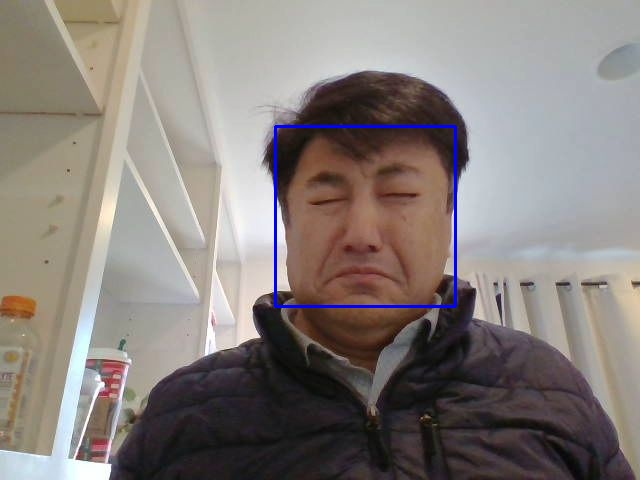

In [29]:
try:
  filename = take_photo('webcamphoto.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [30]:
#b) Start with reading the function for connecting to webcam
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [31]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

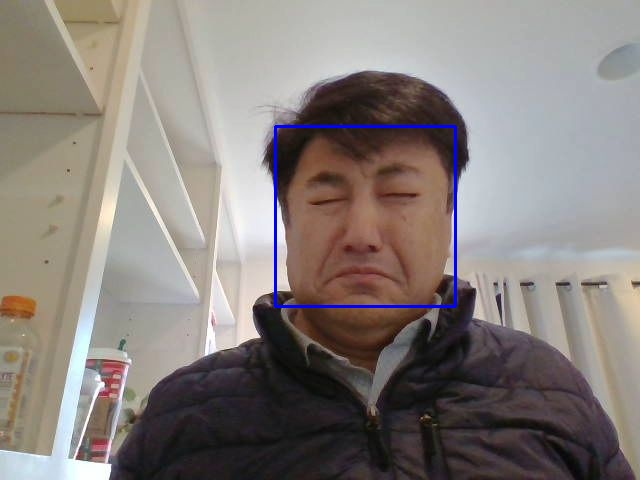

In [65]:
from google.colab.patches import cv2_imshow
import cv2

image = cv2.imread('webcamphoto.jpg')

cv2_imshow(image)


**Real-time video processing**

In [32]:
#c) Real-time video processing
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [33]:
from IPython.display import Javascript


In [34]:
from IPython.display import display, Javascript
from google.colab.output import eval_js

def video_frame(label_html, bbox):
    js = """
    // JavaScript code to create a frame from the webcam video stream
    // This code should capture a frame, process it, and return the result
    """
    display(Javascript(js))
    return eval_js('someJavaScriptFunctionToGetFrame()')  # This function should be defined in your JavaScript code


In [35]:
from base64 import b64decode
import numpy as np
import cv2

def js_to_image(js_reply):
    """
    Convert a JavaScript object to an OpenCV image
    """
    # Decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # Convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # Decode numpy array into OpenCV image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img


In [36]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [37]:
# start streaming video from webcam and classify the emotion
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

model_path = 'emotion-ferplus-8.onnx'
init_emotion(model)
cap = cv2.VideoCapture(0)


fps=0
init_emotion(model)
cap = cv2.VideoCapture(0)

# If you want to use the webcam the pass 0
# cap = cv2.VideoCapture(0)


while(True):

    start_time = time.time()
    ret,frame=cap.read()

    if not ret:
        break

    image = cv2.flip(frame,1)

    image = emotion(image, returndata=True, confidence = 0.8)

    cv2.putText(image, 'FPS: {:.2f}'.format(fps), (10, 20), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 20, 55), 1)
    cv2.imshow("Emotion Recognition",image)

    k = cv2.waitKey(1)
    fps= (1.0 / (time.time() - start_time))

    if k == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


<IPython.core.display.Javascript object>

**deploy online**

In [38]:
!pip install flask_ngrok

In [42]:
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok

deb https://ngrok-agent.s3.amazonaws.com buster main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://ngrok-agent.s3.amazonaws.com buster InRelease [20.3 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 https://ngrok-agent.s3.amazonaws.com buster/main amd64 Packages [3,407 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,547 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,578 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 

In [62]:
!ngrok authtoken "2ZPeoFwbEa9U8OM6TuAEIraIqWe_7yHtddYBhqofUXq26A1Wt"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [63]:
from flask import Flask, request, render_template
import cv2
import numpy as np
import onnxruntime as ort

app = Flask(__name__)

# Function to initialize and load the model
def load_model(model_path='emotion-ferplus-8.onnx'):
    return ort.InferenceSession(model_path)

# Load the model
model = load_model()

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        # Retrieve the file from the form
        file = request.files['file']
        if file:
            # Read the image file
            image_stream = file.stream
            image_array = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

            # Preprocess the image for the model
            # This may vary depending on your model's requirements
            processed_image = preprocess_image(image)

            # Perform inference
            input_name = model.get_inputs()[0].name
            output = model.run(None, {input_name: processed_image})[0]

            # Interpret the output (this will depend on your model's specifics)
            expression = interpret_output(output)

            # Return the result
            return render_template('result.html', expression=expression)

    return render_template('upload.html')

# Function to preprocess the image (modify as needed)
def preprocess_image(image):
    # Example: Resize and normalize
    resized_image = cv2.resize(image, (64, 64))  # Example dimensions
    normalized_image = resized_image / 255.0
    return normalized_image[np.newaxis, :, :, :]

# Function to interpret the model's output (modify as needed)
def interpret_output(output):
    # Example: Assume output is a probability distribution across classes
    expression_classes = ['Happy', 'Sad', 'Angry', 'Surprised', 'Neutral']  # Example classes
    return expression_classes[np.argmax(output)]

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [53]:
!npm install -g localtunnel


/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 1.535s


In [54]:
!lt --port 5000


your url is: https://rare-foxes-repair.loca.lt
^C


In [57]:
!ngrok config add-authtoken 2ZPeoFwbEa9U8OM6TuAEIraIqWe_7yHtddYBhqofUXq26A1Wt

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [59]:
from flask import Flask, request, render_template
import cv2
import numpy as np
import onnxruntime as ort

app = Flask(__name__)

# Function to initialize and load the model
def load_model(model_path='emotion-ferplus-8.onnx'):
    return ort.InferenceSession(model_path)

# Load the model
model = load_model()

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        # Code to process the uploaded file and perform facial expression recognition using the model
        pass
    return render_template('upload.html')

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
